# CT reconstruction by Quantum Annealing

## Preparation

In [1]:
from itertools import product

import cv2
import numpy as np

import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom

In [2]:
rc = {
    "figure.dpi": 150,
    "figure.autolayout": False,
    "font.family": "sans-serif",
    "font.serif": "Roboto",
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
}
sns.set_theme(context="notebook", style="white", rc=rc)

## Compute sinogram from Shepp-Logan phantom

In [3]:
# Load Shepp Logan phantom
image = shepp_logan_phantom()
image = image.astype("float32")
image = np.pad(image, ((56, 56), (56, 56)), mode="constant", constant_values=0)
print(image.shape, image.min(), image.max())

(512, 512) 0.0 1.0


In [4]:
# Shrink image to fit the number of qubits
image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)
print(image.shape)

(32, 32)


In [5]:
# binarize image
image = (image > 0.15).astype("float32")

In [6]:
# Make an image grid
H, W = image.shape
xs = np.arange(0, W)
ys = np.arange(0, H)
xs, ys = np.meshgrid(xs, ys)
ones = np.ones_like(xs)
grid = np.stack([xs, ys, ones], axis=-1)
grid = grid.astype("float32")

In [7]:
# Geometry
N = max(W, H)
angles = np.linspace(0.0, 2.0 * np.pi, N, endpoint=False)

In [8]:
# Compute sinogram
sino = []
for n, a in enumerate(angles):
    theta = np.rad2deg(a)
    rot = cv2.getRotationMatrix2D((W // 2, H // 2), theta, 1.0)
    rot_grid = cv2.warpAffine(
        grid,
        rot,
        (W, H),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_REPLICATE,
    )

    proj = np.zeros(W)
    for j in range(W):
        for i in range(H):
            xp, yp = rot_grid[i, j, :2]
            if xp < 0 or xp >= W - 1 or yp < 0 or yp >= H - 1:
                continue

            xi, yi = int(xp), int(yp)
            xt, yt = xp - xi, yp - yi
            proj[j] += (1 - xt) * (1 - yt) * image[yi, xi]
            proj[j] += xt * (1 - yt) * image[yi, xi + 1]
            proj[j] += (1 - xt) * yt * image[yi + 1, xi]
            proj[j] += xt * yt * image[yi + 1, xi + 1]

    sino.append(proj)

sino = np.stack(sino, axis=0)

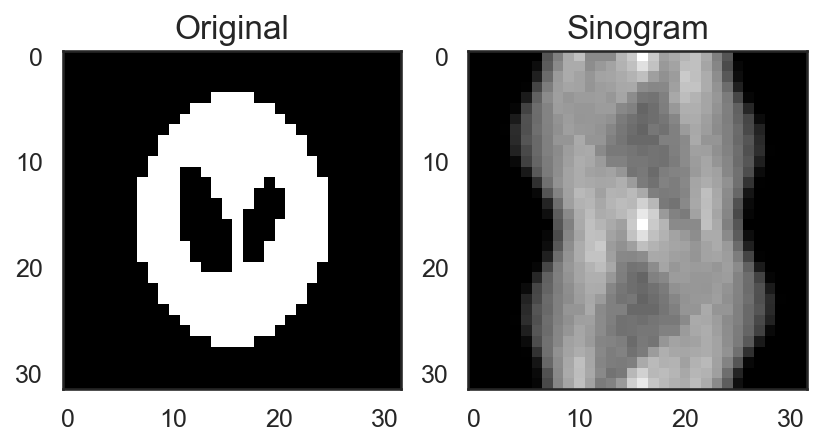

In [9]:
# Show CT image and corresponding sinogram
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image, cmap="gray")
axs[0].set_title("Original")
axs[1].imshow(sino, cmap="gray")
axs[1].set_title("Sinogram")
plt.show()

## CT reconstruction with quantum annealing

In [10]:
from dwave.samplers import SimulatedAnnealingSampler
from pyqubo import Array

In [11]:
# Binary variables
bb = Array.create("bb", shape=(H, W), vartype="BINARY")

# Construct QUBO
L = 0.0
for n, a in enumerate(angles):
    theta = np.rad2deg(a)
    rot = cv2.getRotationMatrix2D((W // 2, H // 2), theta, 1.0)
    rot_grid = cv2.warpAffine(
        grid,
        rot,
        (W, H),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_REPLICATE,
    )

    for j in range(W):
        val = 0.0
        for i in range(H):
            xp, yp = rot_grid[i, j, :2]
            if xp < 0 or xp >= W - 1 or yp < 0 or yp >= H - 1:
                continue

            xi, yi = int(xp), int(yp)
            xt, yt = xp - xi, yp - yi
            val += (1 - xt) * (1 - yt) * bb[yi, xi]
            val += xt * (1 - yt) * bb[yi, xi + 1]
            val += (1 - xt) * yt * bb[yi + 1, xi]
            val += xt * yt * bb[yi + 1, xi + 1]

        L += (val - sino[n, j]) ** 2

In [12]:
# Compile a model
model = L.compile()
bqm = model.to_bqm()

In [13]:
# Perform simulated annealing
sa = SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=100)
decoded_samples = model.decode_sampleset(sampleset)
best_sample = min(decoded_samples, key=lambda x: x.energy)
print(best_sample.energy)

0.0


In [14]:
# Get reconstruction result
pred = np.zeros((H, W), dtype="float32")
for y, x in product(range(H), range(W)):
    try:
        pred[y, x] = best_sample.array("bb", (y, x))
    except KeyError:
        pass

# Error
err = np.abs(image - pred)

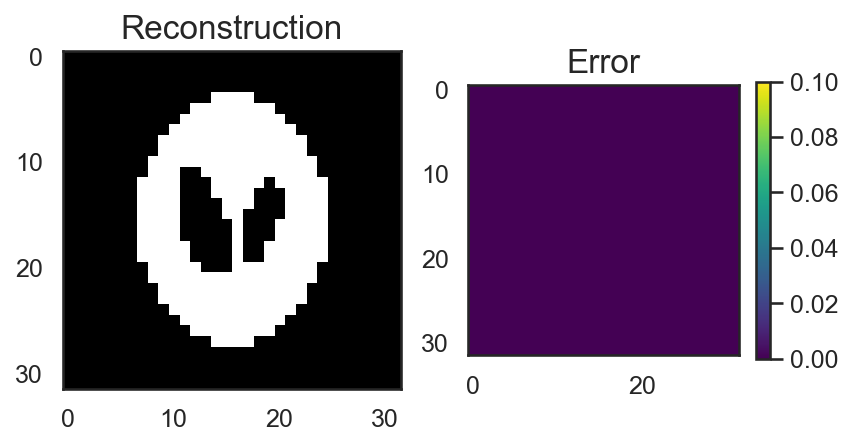

In [15]:
# Show result and error
fig, axs = plt.subplots(1, 2)
axs[0].imshow(pred, cmap="gray")
axs[0].set_title("Reconstruction")
ims_err = axs[1].imshow(err, vmin=0.0, vmax=0.1, cmap="viridis")
fig.colorbar(ims_err, ax=axs[1], shrink=0.5)
axs[1].set_title("Error")
plt.show()